# SLU14 - Model complexity and overfitting: Examples notebook

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
import pandas as pd
from sklearn.datasets import make_classification
from sklearn import feature_selection as fs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier

import utils

In [2]:
df = pd.read_csv('data/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1. Single Factor Analysis on Categoricals

Examine the characteristics of a single variable within a dataset.

### 1.1`nunique`

Count how many unique values exist for a categorical.

In [3]:
df['Ticket'].nunique()

681

### 1.2 `value_counts`

count the occurrences of each category for a feature

In [4]:
df.Cabin.value_counts().head()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
Name: count, dtype: int64

### 1.3 Plot the value counts for all categoricals

Join this knowledge with your plotting skills and check unique counts for each column.

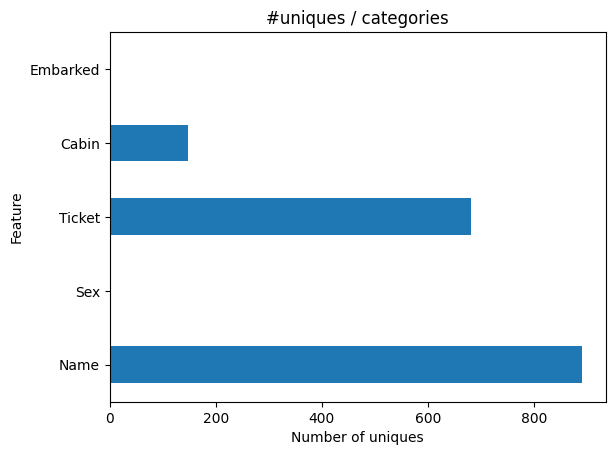

In [5]:
# Plot a barplot of columns:nunique
df.select_dtypes(include='object').nunique().plot.barh()
# Label the plot!
plt.xlabel('Number of uniques');
plt.ylabel('Feature');
plt.title("#uniques / categories");

## 2. Feature Importance

### 2.1 Decision tree feature importances

Using any tree-based estimator, you can get feature importances on a model that has already been fitted

In [6]:
# and this is how we used it

X = df.select_dtypes(exclude='object').fillna(-1).drop('Survived', axis=1)
y = df.Survived

clf = DecisionTreeClassifier(random_state=1, max_depth=5)

In [7]:
# model must be fitted
clf.fit(X, y)
feature_importances = clf.feature_importances_

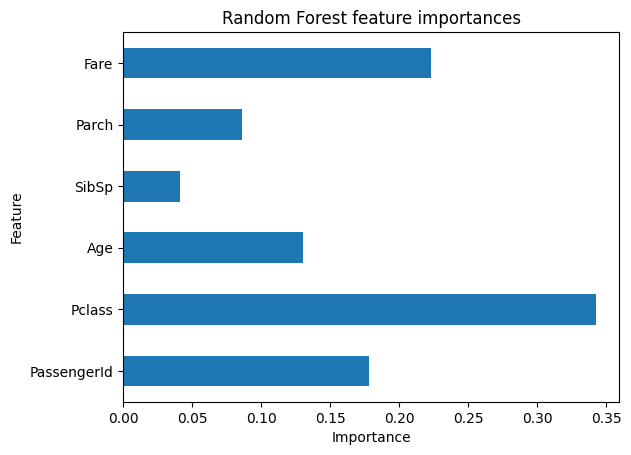

In [8]:
# now you can plot the importances by creating a pandas Series with the correct index

pd.Series(clf.feature_importances_, index=X.columns).plot.barh(title='feature importances');
plt.title('Random Forest feature importances')
plt.xlabel('Importance');
plt.ylabel('Feature');

### 2.2 Logistic regression coefficients

Using linear models that fit coefficients

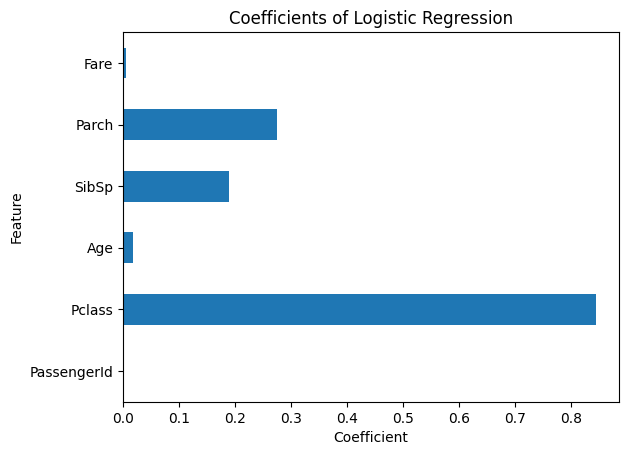

In [9]:
clf = LogisticRegression(random_state=1, solver='lbfgs', max_iter=2000)
clf.fit(X, y)
abs_coefs = pd.Series(clf.coef_[0, :], index=X.columns).abs()
abs_coefs.plot.barh();
plt.title('Coefficients of Logistic Regression')
plt.xlabel('Coefficient');
plt.ylabel('Feature');

### 2.3 Correlations

Computing correlations is pure pandas. 

In [10]:
X.corr()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.035144,0.037997,-0.057527,-0.001652,0.012658
Pclass,-0.035144,1.000000,-0.359728,0.083081,0.018443,-0.549500
Age,0.037997,-0.359728,1.000000,-0.182282,-0.045272,0.135707
SibSp,-0.057527,0.083081,-0.182282,1.000000,0.414838,0.159651
Parch,-0.001652,0.018443,-0.045272,0.414838,1.000000,0.216225
Fare,0.012658,-0.549500,0.135707,0.159651,0.216225,1.000000


## 3. Regularized linear regression


In [11]:
from utils import create_dataset, expand_dataset, L2Normalizer

In [12]:
# Create dummy dataset
data = create_dataset()
original_data = data.copy()
data.head(2)

,x,y
0,0.000000,0.381794
1,0.017453,0.000920


### 3.1 Ridge regression

Loss function (add $L_2$ norm to Mean Squared Error):

$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_2 \sum_{k=1}^K \beta_k^2$$

In [13]:
data = expand_dataset(original_data, 10)

X = data.drop('y', axis=1)
y = data['y']

In [14]:
data.head(2)

,x,y,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9
0,0.000000,0.381794,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.017453,0.000920,0.000305,0.000005,9.279177e-08,1.619522e-09,2.826599e-11,4.933346e-13,8.610313e-15,1.502783e-16


In [15]:
from sklearn.linear_model import Ridge

In [16]:
ridge = Ridge(alpha=0.0001, random_state=10)
ridge.fit(utils.L2Normalizer(X), y)

,alpha,0.0001
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,10


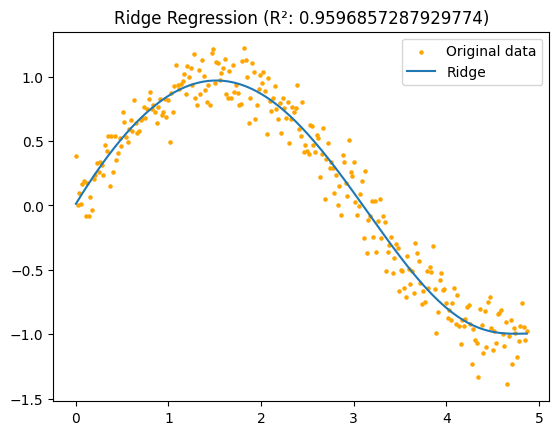

In [17]:
plt.scatter(X['x'], data['y'], c='orange', s=5, label="Original data")
plt.plot(X['x'], ridge.predict(L2Normalizer(X)), label="Ridge")
plt.title('Ridge Regression (R²: {})'.format(ridge.score(L2Normalizer(X), y)));
plt.legend(loc="best");

### 3.2 Lasso regression

Loss function (add $L_1$ norm to Mean Squared Error):

$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \sum_{k=1}^K \left|\beta_k\right|$$

In [18]:
from sklearn.linear_model import Lasso

In [19]:
lasso = Lasso(alpha=0.0002, random_state=10, max_iter=4000, tol=0.005)
lasso.fit(utils.L2Normalizer(X), y)

,alpha,0.0002
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,4000
,tol,0.005
,warm_start,False
,positive,False
,random_state,10
,selection,'cyclic'


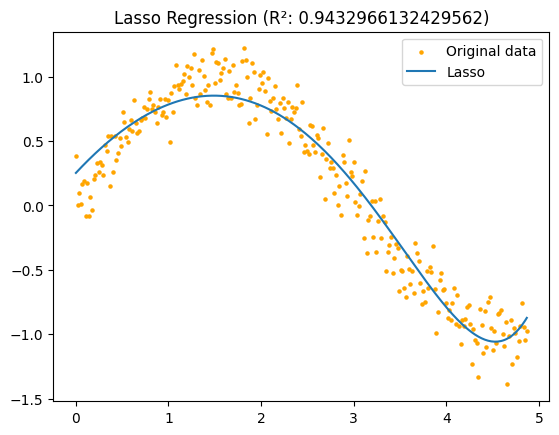

In [20]:
plt.scatter(X['x'], data['y'], c='orange', s=5, label="Original data")
plt.plot(X['x'], lasso.predict(L2Normalizer(X)), label="Lasso")
plt.title('Lasso Regression (R²: {})'.format(lasso.score(L2Normalizer(X), y)));
plt.legend(loc="best");

### 3.3 Elastic net regression

Loss function (add $L_1$ and $L_2$ norms to Mean Squared Error):

$$J = \frac{1}{N} \sum_{n=1}^N (y_n - \hat{y}_n)^2 + \lambda_1 \sum_{k=1}^K \left|\beta_k\right| + \lambda_2 \sum_{k=1}^K \beta_k^2$$

In [21]:
from sklearn.linear_model import ElasticNet

In [22]:
en = ElasticNet(alpha=0.00001, l1_ratio=0.5, random_state=10, max_iter=5000, tol=0.005)
en.fit(utils.L2Normalizer(X), y)

,alpha,1e-05
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,5000
,copy_X,True
,tol,0.005
,warm_start,False
,positive,False
,random_state,10
,selection,'cyclic'


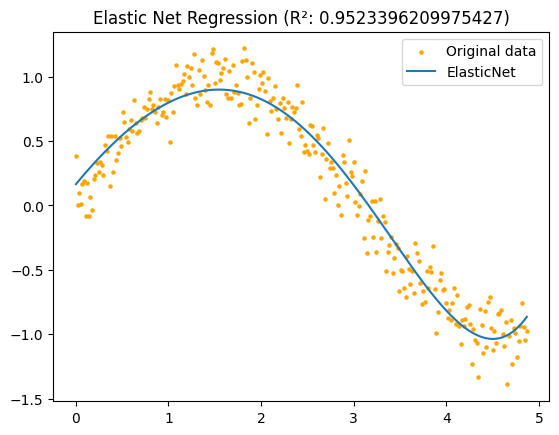

In [23]:
plt.scatter(X['x'], data['y'], c='orange', s=5, label="Original data")
plt.plot(X['x'], en.predict(L2Normalizer(X)), label="ElasticNet")
plt.title('Elastic Net Regression (R²: {})'.format(en.score(L2Normalizer(X), y)));
plt.legend(loc="best");

## 4. Unbalanced data and resampling

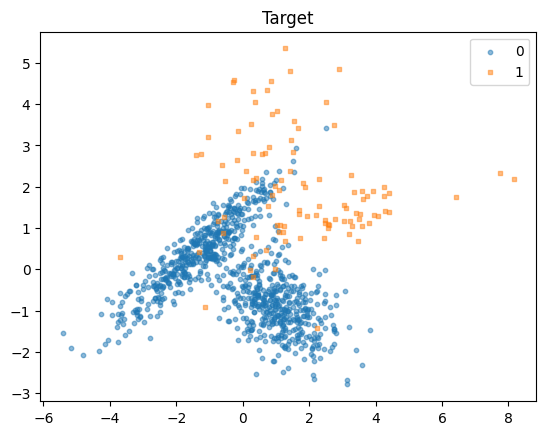

In [24]:
X, y = make_classification(
    n_classes=2, 
    class_sep=1.25, 
    weights=[.9, .1], 
    n_features=20, 
    n_samples=1000, 
    random_state=42
)

utils.plot_classification(X, y)

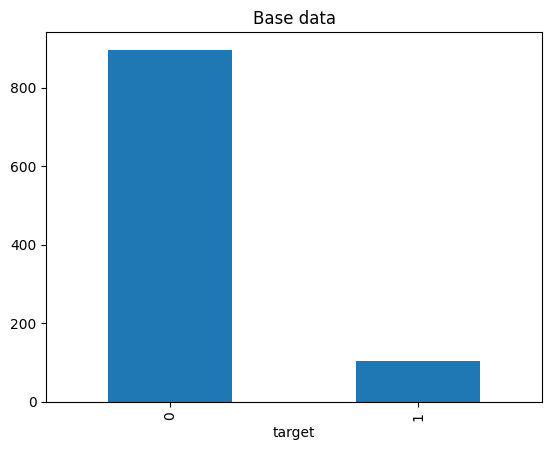

In [25]:
df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Base data');

### 4.1 Random oversampling

Added 345 examples


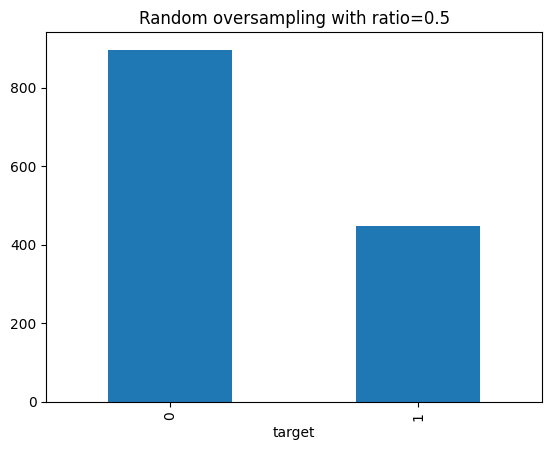

In [26]:
ros_sampler = RandomOverSampler(sampling_strategy=.5, random_state=42)
X_over, y_over = ros_sampler.fit_resample(X, y)

df = pd.DataFrame(X_over)
df['target'] = y_over
df.target.value_counts().plot(kind='bar', title='Random oversampling with ratio=0.5');

print(f'Added {len(y_over) - len(y)} examples')

### 4.2 Oversampling - SMOTE

Added 345 examples


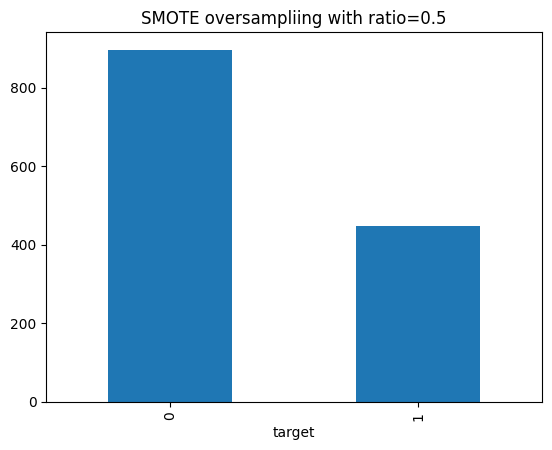

In [27]:
smote_sampler = SMOTE(sampling_strategy=0.5, random_state=42)
X_smote, y_smote = smote_sampler.fit_resample(X, y)

df = pd.DataFrame(X_smote)
df['target'] = y_smote
df.target.value_counts().plot(kind='bar', title='SMOTE oversampliing with ratio=0.5');

print(f'Added {len(y_smote) - len(y)} examples')

### 4.3 Random undersampling

Removed 691 examples


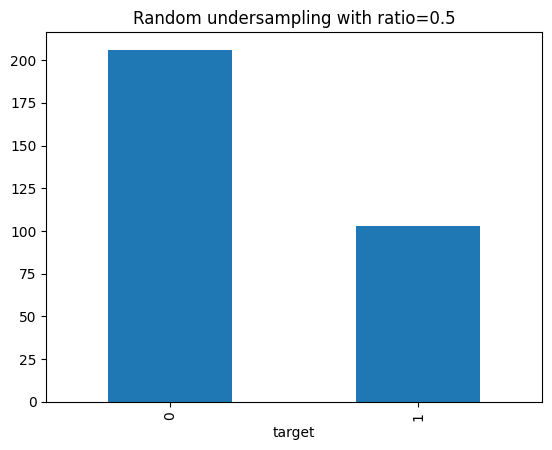

In [28]:
rus_sampler = RandomUnderSampler(sampling_strategy=.5, random_state=42)
X_under, y_under = rus_sampler.fit_resample(X, y)

df = pd.DataFrame(X_under)
df['target'] = y_under
df.target.value_counts().plot(kind='bar', title='Random undersampling with ratio=0.5');

print(f'Removed {len(y) - len(y_under)} examples')

### 4.4 Undersampling - Tomek links

Removed 7 examples


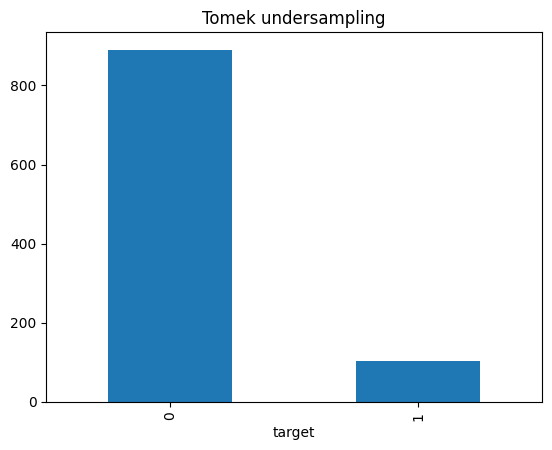

In [29]:
# TomekLinks
tomek_sampler = TomekLinks()
X_tomek, y_tomek = tomek_sampler.fit_resample(X, y)

df = pd.DataFrame(X_tomek)
df['target'] = y_tomek
df.target.value_counts().plot(kind='bar', title='Tomek undersampling');

print(f'Removed {len(y) - len(y_tomek)} examples')